In [53]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

from tools import create_x_y

In [54]:
def encode_y(y):
    if len(set(y)) == 2:
        remap_dict = {-1: 0, 1: 1}
    elif len(set(y)) == 3:
        remap_dict = {-1: 0, 0: 1, 1: 2}
    elif len(set(y)) == 5:
        remap_dict = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}
    for i, val in enumerate(y):
        y[i] = remap_dict[val]

    return y


def weight_data(x):
    # least represented class is 1.0, others are percentage_least/percentage_other
    percentages = {}
    len_x = len(x)
    for uniq_val in set(x):
        percentages[uniq_val] = sum([1 for i in x if i == uniq_val]) / len_x
    least = min(percentages, key=percentages.get)
    weights = {i: percentages[least] / percentages[i] for i in percentages}
    return weights


# match feature importances from vector with multiple lagged vals of each column
def importances_from_lag(x, col_names):
    lag = int(len(x) / len(col_names))
    len_col = len(col_names)
    imp = {
        col_names[i]: sum(x[i * lag : (i + 1) * lag]) / lag
        for i in range(len_col)
    }

    return imp

def save_importances_plot(fi, name, title, cols):
    import seaborn as sns
    importances = importances_from_lag(fi, cols) 
    x_axis = list(importances.keys())
    y_axis = [float(i) for i in importances.values()]
    figure = plt.gcf()
    figure.set_size_inches(9, 6)
    sns.barplot(y=x_axis, x=y_axis).set_title(title)
    
    plt.savefig(f'../plots/{name}.pdf')

In [55]:
def measure(x, y, binary=True):
    mode = "binary:logistic"
    if not binary:
        mode = "multi:softprob"
    clf = xgb.XGBClassifier(objective=mode, random_state=42)#, sample_weight=compute_sample_weight(weight_data(y), y))

    params = {
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 0.5),
        "learning_rate": uniform(0.003, 0.3),  # default 0.1
        "max_depth": randint(2, 6),  # default 3
        "n_estimators": randint(100, 400),  # default 100
        "subsample": uniform(0.6, 0.4), 
    }
    time_split = TimeSeriesSplit(n_splits=5)
    xgb_search = RandomizedSearchCV(
        clf,
        param_distributions=params,
        random_state=42,
        n_iter=20,
        cv=time_split,
        verbose=1,
        n_jobs=4,
    )
    split = int(0.8 * len(x))
    xgb_search.fit(x[:split], y[:split])
    y_pred = xgb_search.predict(x[split:])
    #cm = confusion_matrix(y[split:], y_pred)
    acc = accuracy_score(y[split:], y_pred)
    f1 = f1_score(y[split:], y_pred, average="weighted")

    fi = xgb_search.best_estimator_.feature_importances_

    return acc, f1, fi

['open', 'high', 'low', 'close', 'vol', 'max_comp', 'max_neg', 'max_neu', 'max_pos', 'min_comp', 'min_neg', 'min_neu', 'min_pos', 'std_comp', 'std_neg', 'std_neu', 'std_pos', 'mean_comp', 'mean_neg', 'mean_neu', 'mean_pos', 'median_comp', 'median_neg', 'median_neu', 'median_pos', 'count', 'bin_5']
[[27.3725, 27.0725, 27.1925, 27.4275, 27.1975, 27.3975, 26.8375, 26.9625, 27.18875, 27.07125, 27.194025, 27.33875, 12628997.0, 6291776.0, 5049924.0, 0.8519, 0.8217, 0.9041, 0.355, 0.343, 0.462, 1.0, 1.0, 1.0, 0.483, 0.423, 0.465, -0.5849, -0.9032, -0.7804, 0.0, 0.0, 0.0, 0.517, 0.577, 0.535, 0.0, 0.0, 0.0, 0.3009150163457687, 0.411012664252287, 0.397301212831835, 0.0668042908777427, 0.1247650446789004, 0.0910577752384306, 0.1361051640980789, 0.1386813576654133, 0.1367345245213455, 0.1254507414533175, 0.1025010818742119, 0.1299378795772026, 0.116525352112676, -0.0975063829787234, 0.1703294117647058, 0.0257605633802816, 0.0933404255319149, 0.0406274509803921, 0.892887323943662, 0.85821276595744

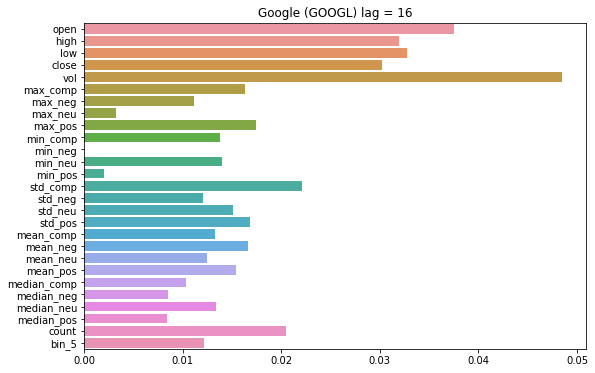

In [56]:
full_names = {
    "aapl": "Apple",
    "msft": "Microsoft",
    "tsla": "Tesla",
    "goog": "Google (GOOG)",
    "googl": "Google (GOOGL)",
}
acc = {}
cm = {}
f1_metric = {}
for company in full_names.keys():
    df = pd.read_csv(f"../datasets/binned/{company}_binned.csv")
    VITAL_COLS = ["date_", "ticker", "bin_2", "diffs", "bin_3"]
    OTHER_COLS = [i for i in df.columns if i not in VITAL_COLS]
    print(OTHER_COLS)
    acc[company] = {}
    f1_metric[company] = {}
    fi = {}

    for lag in [3, 6, 10, 16]:
        x, y = create_x_y(df, x_cols=OTHER_COLS, y_col="bin_5", lag=lag)
        y = encode_y(y)
        print(x[:3], y[:3])
        print(acc, f1_metric, fi)
        acc[company][lag], f1_metric[company][lag], fi[lag] = measure(
            x, y, binary=False
        )

        save_importances_plot(
            fi[lag],
            f"xgb_{company}_imp_{lag}",
            f"{full_names[company]} lag = {lag}",
            OTHER_COLS,
        )


In [57]:
acc

{'aapl': {3: 0.5438084112149533,
  6: 0.5438084112149533,
  10: 0.5441262419637639,
  16: 0.5444444444444444},
 'msft': {3: 0.586527293844367,
  6: 0.5862870424171993,
  10: 0.5886112725159791,
  16: 0.5881326352530541},
 'tsla': {3: 0.32642487046632124,
  6: 0.32700057570523894,
  10: 0.3197004608294931,
  16: 0.31873198847262246},
 'goog': {3: 0.5370159453302962,
  6: 0.5367521367521367,
  10: 0.5370581527936146,
  16: 0.5373645179691957},
 'googl': {3: 0.5282051282051282,
  6: 0.5287749287749288,
  10: 0.5290763968072976,
  16: 0.5293782087849401}}

In [58]:
acc_good = {f"{company}_{lag}": round(acc[company][lag], 4) for lag in acc[company] for company in acc}
f1_good = {f"{company}_{lag}": round(f1_metric[company][lag], 4) for lag in acc[company] for company in acc}

Text(0.5, 1.0, 'F1')

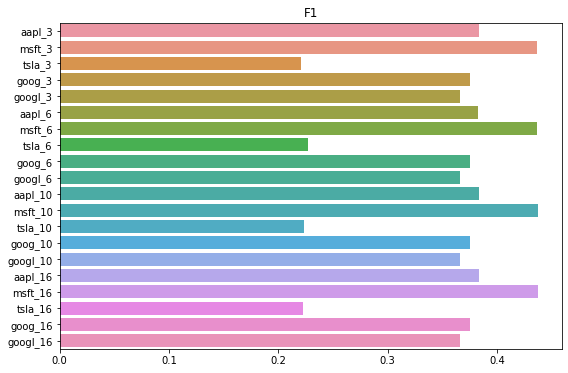

In [59]:
import seaborn as sns

figure = plt.gcf()
figure.set_size_inches(9, 6)
sns.barplot(x=list(f1_good.values()), y=list(f1_good.keys())).set_title("F1")
